First, we manage all imports for the code.

In [25]:
!pip install gensim
!pip install pandas
!pip install nltk
!pip install install -Uq bertopic
!pip install torch
!pip install matplotlib

In [26]:
#imports
import pandas as pd
import numpy as np
import random
import ast
from torch import nn
import torch
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from torch.utils.data import random_split, Subset, DataLoader
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt

import zipfile
import os
import shutil

import bertopic
from sentence_transformers import SentenceTransformer

Next we process the zipped data to csv. It is stored in .zip, because it is smaller on git and then locally it is extracted to csv.

In [27]:
with zipfile.ZipFile("data/dataset.zip", "r") as zip_ref:
    zip_ref.extractall("data")

for file_name in os.listdir("data/dataset"):
    source = "data/dataset/" + file_name
    destination = "data/" + file_name
    if os.path.isfile(source): shutil.move(source, destination)

os.rmdir("data/dataset")
del source, destination

Preprocessing of the datasets, the goal is to receive a table with the following columns: Name, Lyrics, Genre<br>
df Dataset - Name, Lyrics, Genre<br>
df3 Dataset - 10000 entrys of random selectet lyrics to train doc2vec
df4 Dataset - 28k~ entrys of songs

In [28]:

df = pd.read_csv('data/Spotify-2000.csv')
df = df[['Title', 'Top Genre']] #take only the name and genre
df2 = pd.read_csv('data/spotify_millsongdata.csv')
df4 = pd.read_csv('data/tcc_ceds_music.csv')
df4 = df4[['track_name','genre','lyrics']]

df['lyrics'] = '' # add column lyrics
#Now combine those two documents by the title
found = 0

for x, title in enumerate(df['Title']):
    #print(title)
    for y, title2 in enumerate(df2['song']):
        if title2.lower() == title.lower():
            df['lyrics'].iloc[x] = df2['text'].iloc[y]

print("finished combining..")

finished combining..


Collect 10000 random entrys of lyrics from the millsongdata Dataset

In [29]:
df3 = df2['text'].sample(n=10000)
#print(df3)
print('done')

done


In [30]:
#remove songs which were not in both datsets
songs_to_remove = []
for x, lyrics in enumerate(df['lyrics']):
    if lyrics == '':
        songs_to_remove.append(x)
df.drop(songs_to_remove, axis = 0, inplace = True)

print(df)

                  Title          Top Genre  \
0               Sunrise    adult standards   
1           Black Night         album rock   
3         The Pretender  alternative metal   
6     She Will Be Loved                pop   
8        Mr. Brightside        modern rock   
...                 ...                ...   
1988         Summertime    adult standards   
1989   Heartbreak Hotel    adult standards   
1990          Hound Dog    adult standards   
1991    Johnny B. Goode         blues rock   
1993     Blueberry Hill    adult standards   

                                                 lyrics  
0     You take away the breath I was keeping for sun...  
1     Black night is not right,  \r\nI don't feel so...  
3     I'm going to rent myself a house  \r\nIn the s...  
6     Beauty queen of only eighteen she  \r\nHad som...  
8     Coming out of my cage  \r\nAnd I've been doing...  
...                                                 ...  
1988  Summertime....and the livin' is eas

Further preprocessing of the lyrics itself. We remove the stopwords and punctuations with regex and stopwords from ntlk form df and df3

In [31]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
sw = stopwords.words('english')
punc_regex = r'[^\s\w]' #searches for everything thats not a word or space
stopword_regex = r'\b{0}\b'
space_regex = r'\s\s+'
newl_regex = r'\n|\r'

#print(df3.iloc[1])

#preprocessing of df
for x, lyrics in enumerate(df['lyrics']):
    txt = lyrics
    txt = re.sub(punc_regex, '', txt) #remove punuctuations
    for sword in sw:
        txt = re.sub(stopword_regex.format(sword), '', txt, flags=re.IGNORECASE) #remove every stopword
    txt = re.sub(newl_regex, '', txt)
    stemmed_txt = ''
    for word in txt.split():
        stemmed_txt += str(stemmer.stem(word.lower())) + " "
    
    df['lyrics'].iloc[x] = stemmed_txt

print(df)
print('finished preprocessing of df')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                  Title          Top Genre  \
0               Sunrise    adult standards   
1           Black Night         album rock   
3         The Pretender  alternative metal   
6     She Will Be Loved                pop   
8        Mr. Brightside        modern rock   
...                 ...                ...   
1988         Summertime    adult standards   
1989   Heartbreak Hotel    adult standards   
1990          Hound Dog    adult standards   
1991    Johnny B. Goode         blues rock   
1993     Blueberry Hill    adult standards   

                                                 lyrics  
0     take away breath keep sunris appear morn look ...  
1     black night right dont feel bright dont care s...  
3     im go rent hous shade freeway gonna pack lunch...  
6     beauti queen eighteen troubl alway help alway ...  
8     come cage ive fine gotta gotta want start kiss...  
...                                                 ...  
1988  summertimeand livin easi fish jumpi

In [32]:
#preprocessing of df3
for x, lyrics in enumerate(df3):
    txt = lyrics
    txt = re.sub(punc_regex, '', txt) #remove punuctuations
    for sword in sw:
        txt = re.sub(stopword_regex.format(sword), '', txt, flags=re.IGNORECASE) #remove every stopword
    txt = re.sub(newl_regex, '', txt)
    stemmed_txt = ''
    for word in txt.split():
        stemmed_txt += str(stemmer.stem(word.lower())) + " "
        
    df3.iloc[x] = stemmed_txt
    
print(df3)
print('finished preprocessing of df3')

11389    dont want compani dont need take care let long...
48483    morn night stay sight didnt recogn id becom al...
19057    cat tabl wait dinner til children came shoo aw...
20004    time lotsa money id take round world n dime ev...
50840    look hang word everi littl word look stare win...
                               ...                        
2830     there rain window im think tear pillow come jo...
37346    cut away somebodi cut away desper heart cut aw...
38732    sometim rememb reason let go insid see face re...
53923    dont know old found armor belli sixteenth cent...
48720    pogu lorelei told tale love glori old sad song...
Name: text, Length: 10000, dtype: object
finished preprocessing of df3


In [33]:
#preprocessing of df4
for x, lyrics in enumerate(df4['lyrics']):
    txt = lyrics
    txt = re.sub(punc_regex, '', txt) #remove punuctuations
    for sword in sw:
        txt = re.sub(stopword_regex.format(sword), '', txt, flags=re.IGNORECASE) #remove every stopword
    
    txt = re.sub(newl_regex, '', txt)
    stemmed_txt = ''
    for word in txt.split():
        stemmed_txt += str(stemmer.stem(word.lower())) + " "
    df4['lyrics'].iloc[x] = stemmed_txt

print(df4)
print('finished preprocessing of df4')

                          track_name    genre  \
0               mohabbat bhi jhoothi      pop   
1                          i believe      pop   
2                                cry      pop   
3                           patricia      pop   
4                 apopse eida oneiro      pop   
...                              ...      ...   
28367                10 million ways  hip hop   
28368  ante up (robbin hoodz theory)  hip hop   
28369                  whutcha want?  hip hop   
28370                         switch  hip hop   
28371                         r.i.p.  hip hop   

                                                  lyrics  
0      hold time feel break feel untru convinc speak ...  
1      believ drop rain fall grow believ darkest nigh...  
2      sweetheart send letter goodby secret feel bett...  
3      kiss lip want stroll charm mambo chacha mering...  
4      till darl till matter know till dream live apa...  
...                                                  ... 

In [ ]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

#display(df)

topic_model = bertopic.BERTopic(language='english', embedding_model=sentence_model,verbose=True)

topics, probs = topic_model.fit_transform(df["lyrics"])

print(topics)

In [ ]:
print(topic_model.get_topic_info())

print(topic_model.get_topics()[1])

Tokenize the lyrics and create tagged Documents

In [36]:
tagged_data = []
nltk.download('punkt')

for i,d in enumerate(df4['lyrics']):
    tokenized_words = nltk.tokenize.word_tokenize(d)
    tagged_data.append(TaggedDocument(words=tokenized_words, tags=str(i)))

print(len(tagged_data))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


14988


Setting up the Doc2Vec model

In [37]:
doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=1, epochs=30)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

print("Doc2Vec model finished training")

Doc2Vec model finished training


Building the DataLoader for the machine learning model

In [35]:

df4 = df4[df4.genre != "hip hop"]

pre_norm_genre_dict = {}
for i in df4['genre']:
    if i in pre_norm_genre_dict:
        pre_norm_genre_dict[i] += 1
    else:
        pre_norm_genre_dict[i] = 1

for i in pre_norm_genre_dict:
    print(i, pre_norm_genre_dict[i])

min_value = min(pre_norm_genre_dict.values())
print(min_value)

new_df = df4.groupby('genre').sample(min_value)

new_df = new_df.sample(frac = 1)
new_df.reset_index(inplace = True,drop = True)
display(new_df)
df4 = new_df.copy()

pop 7042
country 5445
blues 4604
jazz 3845
reggae 2498
rock 4034
2498


,track_name,genre,lyrics
0,i love hot nights,rock,night tshirt feel right stay later outsid stay...
1,pressure,reggae,special dedic peopl live poverti direct peopl ...
2,inject the venom,rock,want plead need tell truth tell lie cross hear...
3,hanging fire,reggae,yeah come life come life come life babi come t...
4,lavish,jazz,drive insan complain lose word needl day samei...
...,...,...,...
14983,what is this thing called love?,blues,thing call funni thing call solv mysteri fool ...
14984,nineteen somethin',country,bathroom floor night dread shame disgrac prett...
14985,my gift to you,rock,precious long hide shadow break soul want tell...
14986,children of tomorrow,reggae,bargain think children tomorrow tell search st...


In [38]:
columns = ['Token'] + ['Target']
df_for_dataloader = pd.DataFrame(columns = columns)
df_for_dataloader.set_index(columns)

lookup_dict = {}
token_list = []
target_list = []
i = 0
for d in df4["genre"]:
    if d not in lookup_dict:
        lookup_dict[d] = i
        i+=1

for index, df_row in df4.iterrows():
    lyrics_tokenized = nltk.tokenize.word_tokenize(df_row["lyrics"])
    token = [doc2vec_model.infer_vector(lyrics_tokenized)]
    #print(token)
    one_hot_encoded_vector = []
    for x in lookup_dict.keys():
        if df_row["genre"] == x:
            one_hot_encoded_vector.append(1)
        else:
            one_hot_encoded_vector.append(0)
    target = [np.array(one_hot_encoded_vector)] # should be genre
    #row = pd.DataFrame([token + target], columns=['Token', 'Target'])
    #df_for_dataloader = pd.concat([df_for_dataloader, row])
    token_list.append(token)
    target_list.append(target)


Splitting the dataset into train and test (80,20)

In [39]:
data_train, data_test = torch.utils.data.random_split(list(zip(token_list, target_list)), [0.8, 0.2])
print(len(data_train))
print(len(data_test))
    
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=32)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=32)

11991
2997


In [40]:
genre_test_count_dict = {}
for i in data_test:
  if np.argmax(i[1]) in genre_test_count_dict:
    genre_test_count_dict[np.argmax(i[1])] += 1
  else:
    genre_test_count_dict[np.argmax(i[1])] = 1

genre_train_count_dict = {}
for i in data_train:
  if np.argmax(i[1]) in genre_train_count_dict:
    genre_train_count_dict[np.argmax(i[1])] += 1
  else:
    genre_train_count_dict[np.argmax(i[1])] = 1

for i in genre_test_count_dict:
  print(i, genre_test_count_dict[i])

lookup_dict_reverse = {y: x for x, y in lookup_dict.items()}

2 481
3 507
0 487
5 509
1 496
4 517


We define out neurol network model.

In [41]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu') For faster training in the end

class SongModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SongModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = input_size
        self.output_size = output_size
        self.layer_1 =   nn.Linear(self.input_size, self.hidden_size)
        self.layer_2 =   nn.Linear(self.hidden_size, self.hidden_size)
        self.layer_out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax =   nn.Softmax()
        self.sigmoid =   nn.Sigmoid()
        self.tanh =      nn.Tanh()

        nn.init.xavier_uniform_(self.layer_1.weight)
        nn.init.zeros_(self.layer_1.bias)
        nn.init.xavier_uniform_(self.layer_out.weight)
        nn.init.zeros_(self.layer_out.bias)


    def forward(self, d):
        x = self.sigmoid(self.layer_1(d))
        x = self.softmax(self.layer_out(x))
        return x

model = SongModel(dataloader_train.dataset[0][0][0].size, dataloader_train.dataset[0][1][0].size).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

Define lists to save the accuracy and loss in each iteration to plot them later.

In [42]:
acc_train_normal_model = []
acc_test_normal_model = []
loss_train_normal_model = []
loss_test_normal_model = []
genre_acc_train_normal_model = []
genre_acc_test_normal_model = []
for i in range(len(lookup_dict)):
    genre_acc_train_normal_model.append([])
    genre_acc_test_normal_model.append([])

Here is the training and test function for the model.

In [43]:
def train(model, dataloader, optimizer,loss_fn):
    total_loss = 0
    acc = 0
    genre_accuracy = {}
    for x, key in enumerate(lookup_dict):
        genre_accuracy[x] = 0

    for sample in dataloader:
        model_input = sample[0][0]
        should = sample[1][0]
        predict = model(model_input)
        for sample_index in range(len(should)):
            predict_e = predict[sample_index].data.numpy()
            should_e = should[sample_index].numpy()
            if np.where(predict_e == np.amax(predict_e))[0][0] == np.where(should_e == np.amax(should_e))[0][0]:
                acc += 1
                genre_accuracy[np.where(should_e == np.amax(should_e))[0][0]] += 1
        loss = loss_fn(predict, should.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
    loss_train_normal_model.append(total_loss.detach().numpy() / len(dataloader.dataset))
    acc_train_normal_model.append(acc * 100 / len(dataloader.dataset))
    print(f"\tTrain - \tLoss: {loss_train_normal_model[-1]:3.10}, Acc: {acc_train_normal_model[-1]:3.5}%", end="\n")
    for (genre, id_genre) in lookup_dict.items():
        genre_acc_train_normal_model[id_genre].append(round(genre_accuracy[lookup_dict[genre]] * 100 / genre_train_count_dict[id_genre],3))

In [44]:
def test(model, dataloader, loss_fn):
    total_loss = 0
    acc = 0
    genre_accuracy = {}
    for x, key in enumerate(lookup_dict):
        genre_accuracy[x] = 0

    for sample in dataloader:
        model_input = sample[0][0]
        should = sample[1][0]
        predict = model(model_input)
        for sample_index in range(len(should)):
            predict_e = predict[sample_index].data.numpy()
            should_e = should[sample_index].numpy()
            if np.where(predict_e == np.amax(predict_e))[0][0] == np.where(should_e == np.amax(should_e))[0][0]:
                acc += 1
                genre_accuracy[np.where(should_e == np.amax(should_e))[0][0]] += 1

        loss = loss_fn(predict, should.float())
        total_loss += loss

    loss_test_normal_model.append(total_loss.detach().numpy() / len(dataloader.dataset))
    acc_test_normal_model.append(acc * 100 / len(dataloader.dataset))
    print(f"\tEvaluation - \tLoss: {loss_test_normal_model[-1]:3.10}, Acc: {acc_test_normal_model[-1]:3.5}%", end="\n")
    for (genre, id_genre) in lookup_dict.items():
        genre_acc_test_normal_model[id_genre].append(round(genre_accuracy[lookup_dict[genre]] * 100 / genre_test_count_dict[id_genre],3))

In [45]:
epochs = 200
for t in range(epochs):
    print("Epoch " + str(t) + ":")
    train(model, dataloader_train, optimizer, loss_fn)
    test(model, dataloader_test, loss_fn)
    torch.save(model.state_dict(), "model_test")

Epoch 0:
	Train - 	Loss: 0.05555806157, Acc: 22.425%
	Evaluation - 	Loss: 0.05557510636, Acc: 23.991%
Epoch 1:
	Train - 	Loss: 0.05520167958, Acc: 23.926%
	Evaluation - 	Loss: 0.05541953493, Acc: 25.058%
Epoch 2:
	Train - 	Loss: 0.05504256875, Acc: 25.06%
	Evaluation - 	Loss: 0.05532046227, Acc: 25.592%
Epoch 3:
	Train - 	Loss: 0.05492659127, Acc: 25.719%
	Evaluation - 	Loss: 0.05524668345, Acc: 25.626%
Epoch 4:
	Train - 	Loss: 0.0548339518, Acc: 26.22%
	Evaluation - 	Loss: 0.05518813797, Acc: 26.226%
Epoch 5:
	Train - 	Loss: 0.05475710176, Acc: 26.495%
	Evaluation - 	Loss: 0.05514000939, Acc: 26.426%
Epoch 6:
	Train - 	Loss: 0.05469181639, Acc: 26.728%
	Evaluation - 	Loss: 0.05509950767, Acc: 26.894%
Epoch 7:
	Train - 	Loss: 0.0546353114, Acc: 26.979%
	Evaluation - 	Loss: 0.05506484573, Acc: 27.06%
Epoch 8:
	Train - 	Loss: 0.05458580019, Acc: 27.22%
	Evaluation - 	Loss: 0.05503478637, Acc: 27.227%
Epoch 9:
	Train - 	Loss: 0.05454178626, Acc: 27.404%
	Evaluation - 	Loss: 0.05500843352,

	Train - 	Loss: 0.05376015349, Acc: 30.348%
	Evaluation - 	Loss: 0.0547174728, Acc: 26.126%
Epoch 81:
	Train - 	Loss: 0.05375633593, Acc: 30.323%
	Evaluation - 	Loss: 0.05471760518, Acc: 26.159%
Epoch 82:
	Train - 	Loss: 0.05375252346, Acc: 30.348%
	Evaluation - 	Loss: 0.05471773755, Acc: 26.159%
Epoch 83:
	Train - 	Loss: 0.05374881788, Acc: 30.389%
	Evaluation - 	Loss: 0.05471790048, Acc: 26.159%
Epoch 84:
	Train - 	Loss: 0.0537451632, Acc: 30.414%
	Evaluation - 	Loss: 0.05471805831, Acc: 26.193%
Epoch 85:
	Train - 	Loss: 0.05374154924, Acc: 30.423%
	Evaluation - 	Loss: 0.05471826705, Acc: 26.159%
Epoch 86:
	Train - 	Loss: 0.05373799128, Acc: 30.423%
	Evaluation - 	Loss: 0.05471847071, Acc: 26.159%
Epoch 87:
	Train - 	Loss: 0.05373444858, Acc: 30.431%
	Evaluation - 	Loss: 0.05471868964, Acc: 26.159%
Epoch 88:
	Train - 	Loss: 0.0537310026, Acc: 30.448%
	Evaluation - 	Loss: 0.05471893402, Acc: 26.193%
Epoch 89:
	Train - 	Loss: 0.05372758715, Acc: 30.439%
	Evaluation - 	Loss: 0.054719203

	Train - 	Loss: 0.05355768026, Acc: 31.223%
	Evaluation - 	Loss: 0.05475245041, Acc: 25.859%
Epoch 161:
	Train - 	Loss: 0.05355594455, Acc: 31.232%
	Evaluation - 	Loss: 0.05475299518, Acc: 25.859%
Epoch 162:
	Train - 	Loss: 0.05355420883, Acc: 31.223%
	Evaluation - 	Loss: 0.05475352977, Acc: 25.859%
Epoch 163:
	Train - 	Loss: 0.05355247311, Acc: 31.198%
	Evaluation - 	Loss: 0.05475407455, Acc: 25.826%
Epoch 164:
	Train - 	Loss: 0.05355074248, Acc: 31.215%
	Evaluation - 	Loss: 0.05475462442, Acc: 25.826%
Epoch 165:
	Train - 	Loss: 0.0535490424, Acc: 31.215%
	Evaluation - 	Loss: 0.05475515901, Acc: 25.792%
Epoch 166:
	Train - 	Loss: 0.05354737285, Acc: 31.223%
	Evaluation - 	Loss: 0.05475569869, Acc: 25.792%
Epoch 167:
	Train - 	Loss: 0.0535457033, Acc: 31.232%
	Evaluation - 	Loss: 0.05475623328, Acc: 25.792%
Epoch 168:
	Train - 	Loss: 0.05354398795, Acc: 31.223%
	Evaluation - 	Loss: 0.05475676788, Acc: 25.792%
Epoch 169:
	Train - 	Loss: 0.05354235403, Acc: 31.207%
	Evaluation - 	Loss: 0

Here it is possible to save or load models

In [ ]:
torch.save(model.state_dict(), "model_40p_train_test")

In [ ]:
model.load_state_dict(torch.load("model_40p_train_test"))
model.eval()

Now we plot our results.

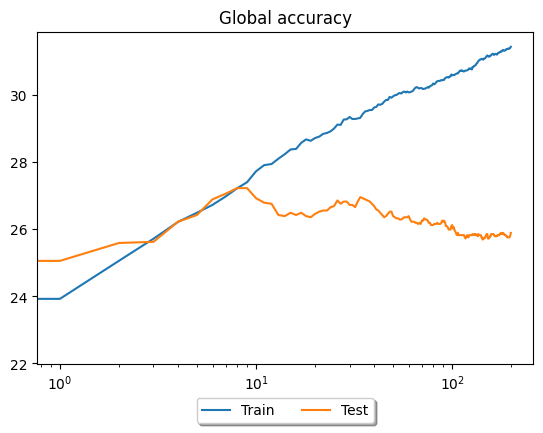

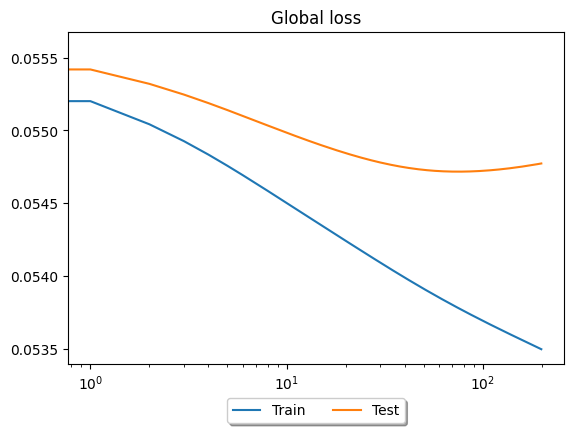

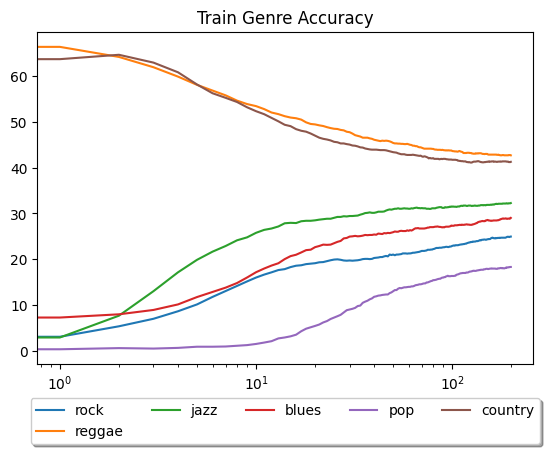

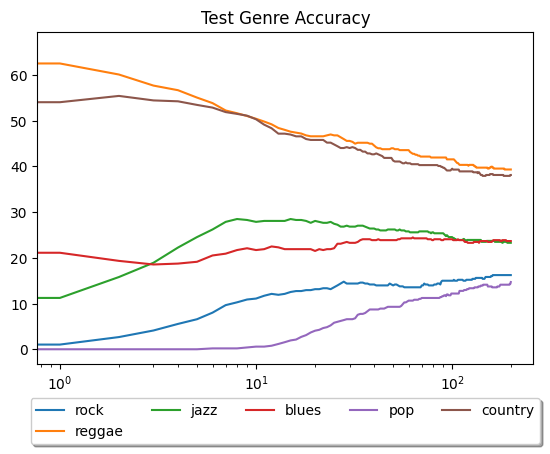

In [46]:
ax_array = []

fig1, ax1 = plt.subplots(1,1)
ax1.semilogx(range(epochs), acc_train_normal_model, label="Train")
ax1.semilogx(range(epochs), acc_test_normal_model, label="Test")
ax1.set_title("Global accuracy")
ax_array.append(ax1)

fig2, ax2 = plt.subplots(1,1)
ax2.semilogx(range(epochs), loss_train_normal_model, label="Train")
ax2.semilogx(range(epochs), loss_test_normal_model, label="Test")
ax2.set_title("Global loss")
ax_array.append(ax2)


fig3, ax3 = plt.subplots(1,1)
for i in range(len(genre_acc_train_normal_model)):
    ax3.semilogx(range(epochs), genre_acc_train_normal_model[i], label=lookup_dict_reverse[i])

fig4, ax4 = plt.subplots(1,1)
for i in range(len(genre_acc_test_normal_model)):
    ax4.semilogx(range(epochs), genre_acc_test_normal_model[i], label=lookup_dict_reverse[i])

ax3.set_title("Train Genre Accuracy")
ax_array.append(ax3)

ax4.set_title("Test Genre Accuracy")
ax_array.append(ax4)

for ax_p in ax_array:
    box = ax_p.get_position()
    ax_p.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax_p.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=True, ncol=5)

if not os.path.isdir("plots"): os.mkdir("plots")
fig1.savefig("plots/global_accuracy.png")
fig2.savefig("plots/global_loss.png")
fig3.savefig("plots/train_genre_accuracy.png")
fig4.savefig("plots/test_genre_accuracy.png")